In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from copy import deepcopy
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
from IPython.display import clear_output
import torchvision
from torch.utils.data import DataLoader

In [ ]:
class CustomResnet(nn.Module):
    def __init__(self, class_nums=10):
        super(CustomResnet, self).__init__()
    
        self.excitation = nn.Sequential( # 3, 32, 32
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 16, 16, 16
            nn.ReLU(), 
            nn.BatchNorm2d(16), 
            BasicBlock(16, '-'), #16
            BasicBlock(16, '+'),  # 32
            BasicBlock(32, '-'), #32
            BasicBlock(32, '+'),  # 64
            BasicBlock(64, '-'), #64
            BasicBlock(64, '-'),  # 64
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 10),
        )

    def forward(self, batch):
        scores = self.excitation(batch)
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample):  
        super(BasicBlock, self).__init__()
       
        self.downsample = downsample

        if self.downsample == '+':
                        # y = F (x, {Wi }) + Ws x.
            self.Ws = nn.Conv2d(
                in_channels, 2*in_channels, kernel_size=1, stride=2
            )
            self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(
                in_channels, 2*in_channels, kernel_size=3, stride=2, padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(2*in_channels),
            )

        else:
                #y = F (x, {Wi }) + x
            self.Ws = None
            self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(
                in_channels, in_channels, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(in_channels),
            )
       

    def forward(self, x):
        identity = x
        out = self.conv(x)
        if self.downsample == '+':
            identity = self.Ws(identity)
        return out + identity

In [ ]:
cifar10_mean = (0.491, 0.482, 0.447)
cifar10_std = (0.247, 0.244, 0.262)
cifar10_normalize = transforms.Normalize(cifar10_mean, cifar10_std)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        cifar10_normalize,
    ]
)

train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        cifar10_normalize,
        transforms.RandomCrop(size=32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)


# Download test set
testset = datasets.CIFAR10(
    "content", train=False, transform=test_transforms, download=True
)

# Download train set
trainset = datasets.CIFAR10(
    "content", train=True, transform=train_transforms, download=True
)

train_cifar_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_cifar_loader = DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 48865499.90it/s]


Extracting content/cifar-10-python.tar.gz to content
Files already downloaded and verified


In [ ]:
class BaseTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader,
    ):
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(model.parameters())
        self.scheduler = None
        self.num_epochs = 3
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.best_model = None
        self.set_score_function(accuracy_score, "accuracy")
        self.pp = ProgressPlotter(title="baseline", groups=["loss"])

    def set_score_function(self, score_function, title="quality metric"):
        self.score_function = score_function
        self.quality_metric = title

    def train_epoch(self):

        self.model.train()
        loss_hist = []
        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()
            preds = self.model(images.to(self.device))
            loss = self.criterion(preds, labels.to(self.device))
            loss.backward()
            loss_hist.append(loss.detach().cpu())
            self.optimizer.step()
        return torch.stack(loss_hist).mean().item()

    def val_epoch(self):
        loss_hist = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in self.test_dataloader:
                preds = self.model(images.to(self.device))
                loss = self.criterion(preds, labels.to(self.device))
                loss_hist.append(loss.detach().cpu())
        return torch.stack(loss_hist).mean()

    def fit(self, verbose=True):
        self.model.to(self.device)
        best_metric_on_val = -np.inf
        
        for epoch in tqdm(range(self.num_epochs)):
            loss_on_train = self.train_epoch()
            loss_on_val = self.val_epoch()
            
            if self.scheduler is not None:
                self.scheduler.step()
            
            metric_on_train = self.validate(on_train=True)
            metric_on_val = self.validate(on_train=False)

            if metric_on_val > best_metric_on_val:
                print("Best model updated")
                best_metric_on_val = metric_on_val
                self.save_best_model()

            self.pp.add_scalar(group="loss", value=loss_on_train, tag="train")
            self.pp.add_scalar(group="loss", value=loss_on_val, tag="val")
            self.pp.add_scalar(
                group=self.quality_metric, value=metric_on_train, tag="train"
            )
            self.pp.add_scalar(
                group=self.quality_metric, value=metric_on_val, tag="val"
            )

            if verbose:
                self.pp.display()

    def validate(self, on_train=False, using_best_model=False, **kwargs):

        dl = self.train_dataloader if on_train else self.test_dataloader
        model = self.best_model if using_best_model else self.model

        y_pred, y_true = self.get_predictions(model, dl)
        return self.score_function(y_pred, y_true, **kwargs)

    def give_best_model(self, on_train=False, using_best_model=False, **kwargs):

        dl = self.train_dataloader if on_train else self.test_dataloader
        model = self.best_model if using_best_model else self.model
        return model

    def get_predictions(self, model, dl):
        y_pred = torch.tensor([])
        y_true = torch.tensor([])

        with torch.no_grad():
            for i, data in enumerate(dl):
                img, label = data
                outputs = model(img.to(self.device))
                _, predicted = torch.max(outputs.data, 1)
                y_pred = torch.cat((y_pred, predicted.cpu().detach()))
                y_true = torch.cat((y_true, label))
        return y_pred, y_true

    def save_best_model(
        self,
    ):
        model_copy = deepcopy(self.model)
        self.best_model = model_copy

In [ ]:
class ProgressPlotter:

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="best")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [ ]:
custom_resnet = CustomResnet()

trainer = BaseTrainer(
    model=custom_resnet , 
    train_dataloader=train_cifar_loader , 
    test_dataloader=test_cifar_loader ,
)

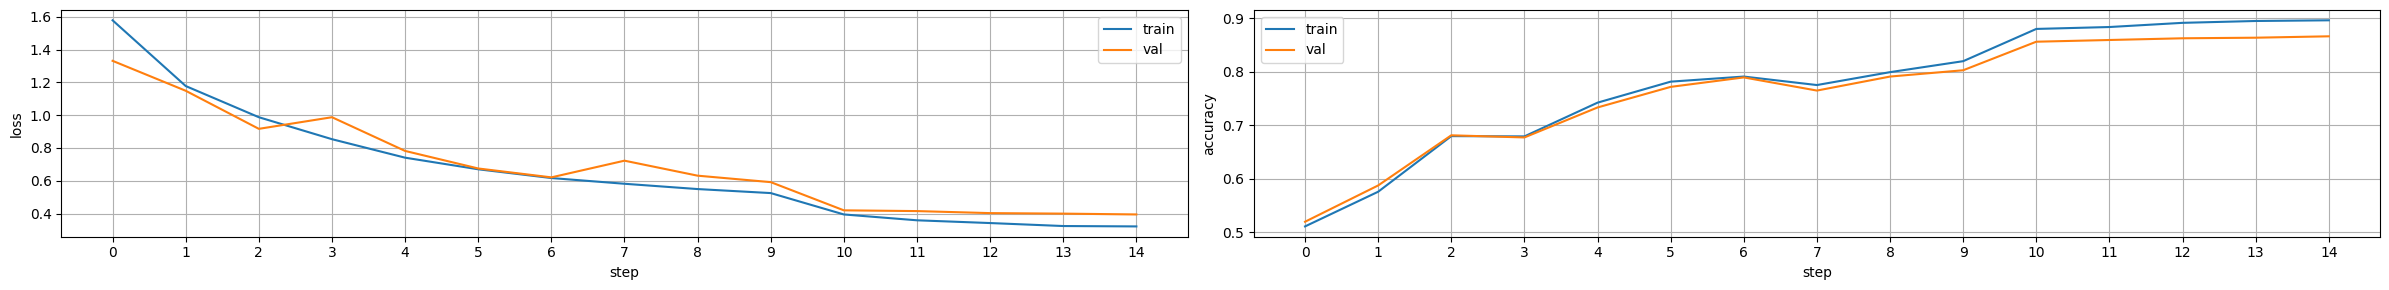

CPU times: user 3min 29s, sys: 17.5 s, total: 3min 46s
Wall time: 13min 20s


In [ ]:
%%time

trainer.optimizer = torch.optim.AdamW(trainer.model.parameters(), lr=0.01)
trainer.scheduler = torch.optim.lr_scheduler.MultiStepLR(trainer.optimizer, milestones=[10,13], gamma=0.1)
trainer.num_epochs = 15
trainer.fit()

In [ ]:
trainer.validate(on_train=False, using_best_model=True)

0.8661